# BigQuery US Name Data Exploration

Coded by Luna McBride. I made this to test out BigQuery.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt #Plotting
%matplotlib inline

plt.rcParams['figure.figsize'] = (15,10) #Set the default figure size
plt.style.use('ggplot') #Set the plotting method

from google.cloud import bigquery #Use BigQuery for data manipulation

bq = bigquery.Client() #Get a BigQuery client

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Using Kaggle's public dataset BigQuery integration.


In [2]:
#Build a query to get everything from the 1910-now names
initialNames = """
select
    *
from 
    `bigquery-public-data.usa_names.usa_1910_current`
limit 100
"""
namesTest = bq.query(initialNames).to_dataframe() #Get a dataframe from the query data
namesTest.head() #Take a peek at the data

,state,gender,year,name,number
0,CT,F,2005,Hope,12
1,CT,F,2005,Jayda,12
2,CT,F,2005,Jayla,12
3,CT,F,2005,Juliette,12
4,CT,F,2005,Katharine,12


---

# Most Popular Names

In [3]:
#Build a query to get the most popular names in the 1910-now dataset
popular = """
select
    name, sum(number) as cases
from
    `bigquery-public-data.usa_names.usa_1910_current`
group by name
order by cases desc
"""
popularNames = bq.query(popular).to_dataframe() #Run the query to get the most popular names
popularNames.head(20) #Get the top 20 most popular names

,name,cases
0,James,5029035
1,John,4894381
2,Robert,4754178
3,Michael,4377398
4,William,3914954
5,Mary,3753203
6,David,3615136
7,Richard,2546952
8,Joseph,2537788
9,Charles,2287121


---

# Find My Name

In [4]:
#Get the popularity of my name
me = """
select
    name, sum(number) as cases
from
    `bigquery-public-data.usa_names.usa_1910_current`
where name = 'Luna'
group by name
"""
myName = bq.query(me).to_dataframe() #Run the query to get the popularity of my name
myName.head() #Take a peek

,name,cases
0,Luna,38916


There are more of me than I thought.

---

# Most Popular Name by Gender

In [5]:
#Build a query in order to get the most popular male names
popularMale = """
select
    name, gender, sum(number) as cases
from
    `bigquery-public-data.usa_names.usa_1910_current`
where gender = 'M'
group by name, gender
order by cases desc
"""
popMale = bq.query(popularMale).to_dataframe() #Put the popular male names into a dataframe
popMale.head() #Take a peek at the popular male names

,name,gender,cases
0,James,M,5010765
1,John,M,4878703
2,Robert,M,4739061
3,Michael,M,4360172
4,William,M,3904738


In [6]:
#Build a query in order to get the most popular female names
popularFemale = """
select
    name, gender, sum(number) as cases
from
    `bigquery-public-data.usa_names.usa_1910_current`
where gender = 'F'
group by name, gender
order by cases desc
"""
popFemale = bq.query(popularFemale).to_dataframe() #Put the popular male names into a dataframe
popFemale.head() #Take a peek at the popular male names

,name,gender,cases
0,Mary,F,3743561
1,Patricia,F,1569296
2,Elizabeth,F,1545720
3,Jennifer,F,1466943
4,Linda,F,1448280


I was entirely expecting the popular male names, but besides Mary and Linda, the female names were pretty surprising

---

# Most Unpopular Names by Gender

In [7]:
#Build a query in order to get the most unpopular male names
unpopularMale = """
select
    name, gender, sum(number) as cases
from
    `bigquery-public-data.usa_names.usa_1910_current`
where gender = 'M'
group by name, gender
order by cases 
"""
unpopMale = bq.query(unpopularMale).to_dataframe() #Put the unpopular male names into a dataframe
unpopMale.head(10) #Take a peek at the unpopular male names

,name,gender,cases
0,Evart,M,5
1,Deo,M,5
2,Arend,M,5
3,Hartwell,M,5
4,Joann,M,5
5,Rae,M,5
6,Steed,M,5
7,Diarra,M,5
8,Gjon,M,5
9,Boban,M,5


In [8]:
#Build a query in order to get the most unpopular female names
unpopularFemale = """
select
    name, gender, sum(number) as cases
from
    `bigquery-public-data.usa_names.usa_1910_current`
where gender = 'F'
group by name, gender
order by cases
"""
unpopFemale = bq.query(unpopularFemale).to_dataframe() #Put the unpopular female names into a dataframe
unpopFemale.head(10) #Take a peek at the unpopular female names

,name,gender,cases
0,Hilja,F,5
1,Alyda,F,5
2,Virgiline,F,5
3,Glenadine,F,5
4,Narice,F,5
5,Arlayne,F,5
6,Merikay,F,5
7,Cheril,F,5
8,Rande,F,5
9,Lezlee,F,5


The most unpopular male names are either pretty strange or are literally female names being used for males. The most unpopular female names appear to mostly be strange spellings of other names, with the occasional fully strange name.

---

# Popular Names by State

In [9]:
#Build a query in order to get the most popular names by state
popularState = """
select * from (
    select
        name, state, sum(number) as cases, rank() over (partition by state order by sum(number) desc) as position
    from
        `bigquery-public-data.usa_names.usa_1910_current`
    group by name, state
    order by state)
where position = 1
"""
popState = bq.query(popularState).to_dataframe() #Put the popular names by state into a dataframe
popState.head(50) #Take a peek at the popular names by state

,name,state,cases,position
0,Michael,AK,8243,1
1,James,AL,159118,1
2,James,AR,85870,1
3,Michael,AZ,46383,1
4,Michael,CA,432472,1
5,Michael,CO,49554,1
6,John,CT,80222,1
7,John,DC,34449,1
8,John,DE,15305,1
9,Michael,FL,144886,1


The majority of the names here are male. Perhaps female names tend to just be more unique overall?

---

# Popular Names by State and Gender

In [10]:
#Build a query in order to get the most popular male names by state
popularMState = """
select * from (
    select
        name, state, gender, sum(number) as cases, rank() over (partition by state order by sum(number) desc) as position
    from
        `bigquery-public-data.usa_names.usa_1910_current`
    where gender = 'M'
    group by name, state, gender
    order by state)
where position = 1
"""
popMState = bq.query(popularMState).to_dataframe() #Put the popular male names by state into a dataframe
popMState.head(50) #Take a peek at the popular male names by state

,name,state,gender,cases,position
0,Michael,AK,M,8243,1
1,James,AL,M,158294,1
2,James,AR,M,85429,1
3,Michael,AZ,M,46180,1
4,Michael,CA,M,430038,1
5,Michael,CO,M,49371,1
6,John,CT,M,80070,1
7,John,DC,M,34433,1
8,John,DE,M,15305,1
9,Michael,FL,M,144194,1


People are not very creative in naming boys.

In [11]:
#Build a query in order to get the most popular female names by state
popularFState = """
select * from (
    select
        name, state, gender, sum(number) as cases, rank() over (partition by state order by sum(number) desc) as position
    from
        `bigquery-public-data.usa_names.usa_1910_current`
    where gender = 'F'
    group by name, state, gender
    order by state)
where position = 1
"""
popFState = bq.query(popularFState).to_dataframe() #Put the popular female names by state into a dataframe
popFState.head(50) #Take a peek at the popular female names by state

,name,state,gender,cases,position
0,Mary,AK,F,3968,1
1,Mary,AL,F,116032,1
2,Mary,AR,F,58689,1
3,Mary,AZ,F,22894,1
4,Jennifer,CA,F,175084,1
5,Mary,CO,F,31734,1
6,Mary,CT,F,41727,1
7,Mary,DC,F,22399,1
8,Mary,DE,F,8414,1
9,Mary,FL,F,66542,1


Nevermind.

---

# Data Visualization

## Male Names

Text(0, 0.5, 'Count')

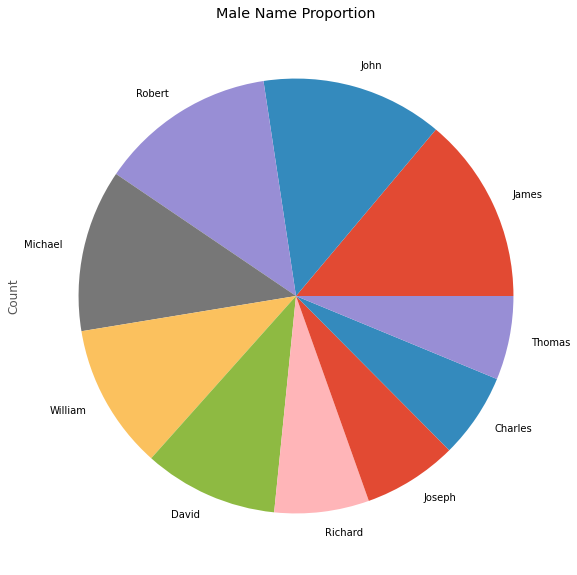

In [12]:
male = popMale.head(10) #Get the top 10 male names
male = male.set_index("name") #Set the index to the name
male["cases"].plot.pie(title = "Male Name Proportion") #Plot a pie chart for the names
plt.ylabel("Count") #Put the y label of "count"

The top 10 male names are pretty proportional to one another, suggesting a span of many popular names.

Text(0, 0.5, 'Count')

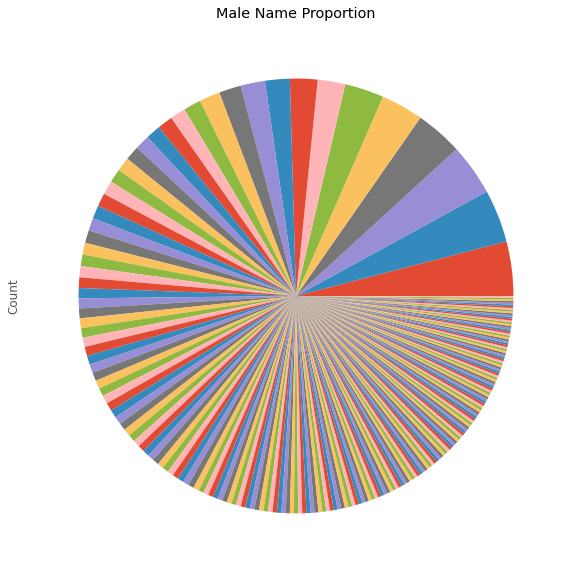

In [13]:
male = popMale.head(210) #Build a pie for a whole lot of names
male = male.set_index("name") #Set the index to the names
male["cases"].plot.pie(title = "Male Name Proportion", labels = None) #Plot the names, removing the actual names because it is crazy with them
plt.ylabel("Count") #Put the y label of "count"

I have added this, with 210 names, to show that these are still a relatively small proportion of names. They just take up a bigger chunk than most others since there are just so many people in the dataset

## Female Names

Text(0, 0.5, 'Count')

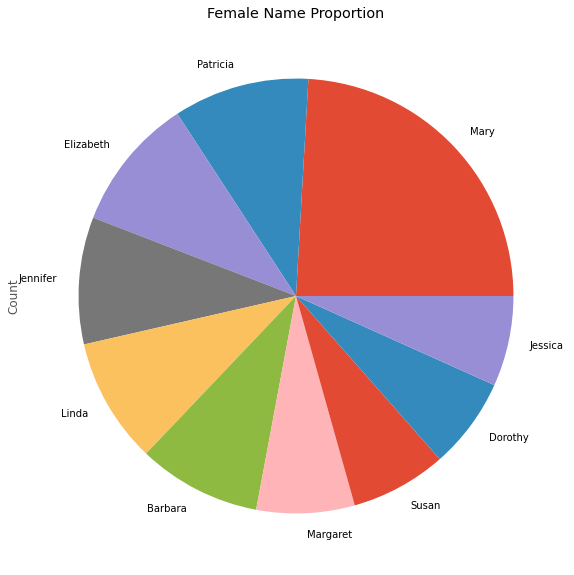

In [14]:
female = popFemale.head(10) #Get the top 10 female names
female = female.set_index("name") #Set the names to the index
female["cases"].plot.pie(title = "Female Name Proportion") #Build a pie for the female names
plt.ylabel("Count") #Put the y label of "count"

There appear to be a fair spread of female names, but Mary skews the data by being comparatively massive. The counts for all other names are similar if Mary is ignored.

## States Most Popular Male Names

Text(0, 0.5, 'Count')

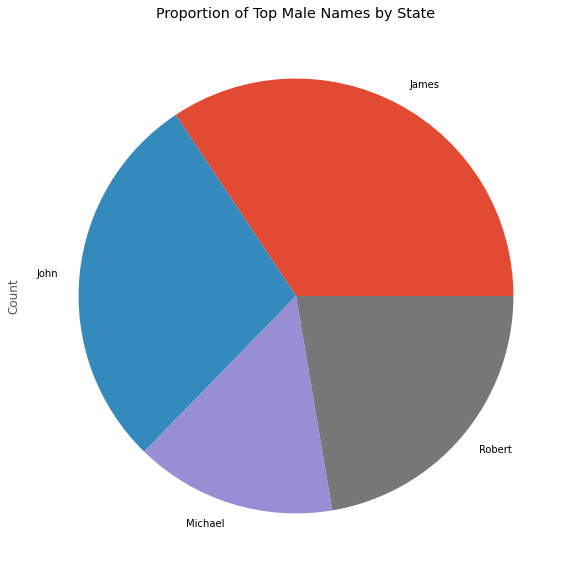

In [15]:
mstate = popMState.head(50) #Get the top male names for every state
mstate = mstate.set_index("name") #Set the names to the index
mstate = mstate.groupby(mstate.index).sum() #Sum them up to get a single representation per name
mstate["cases"].plot.pie(title = "Proportion of Top Male Names by State") #Plot the names in a pie chart
plt.ylabel("Count") #Put the y label of "count"

The top male names seem to have a fairly even spread between the names James, John, Michael, and Robert. James and John seem to hedge above Michael and Robert a bit, but not by much.

## States Most Popular Female Names

Text(0, 0.5, 'Count')

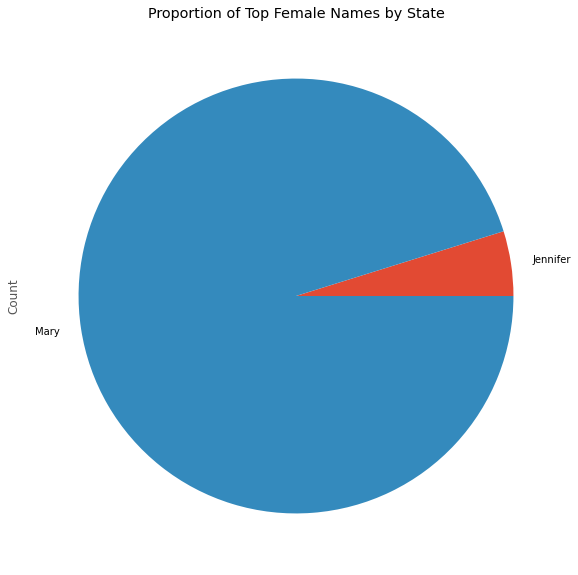

In [16]:
fstate = popFState.head(50) #Get the top female names by state
fstate = fstate.set_index("name") #Set the names to the index
fstate = fstate.groupby(fstate.index).sum() #Sum the names together to get a single representation per name
fstate["cases"].plot.pie(title = "Proportion of Top Female Names by State") #Plot a pie chart of the top female names by state
plt.ylabel("Count") #Put the y label of "count"

Look at all those Marys. 